In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

# This notebook will discuss a mock small-loan eligibility problem: 
## I'm going to apply classification machine learning models to determine whether accounts will qualify for small loans. Based only on their bank transaction data. The training labels are based on previous loans being paid back on time or not.

Steps:
1. Process/transform/clean and visualize raw data. 

2. Feature engineering: Select Features based on objective: Predict loan eligibility based on bank transaction data. Define 'loan_eligibility' based on rules and thresholds.

3. Exploratory Data Analysis / Data Visualization: Histograms, box plots, and scatter plots to understand feature distributions and relationships. Correlation Analysis: Identify correlations between features and target variable (Descriptive Statistics: Summary statistics of the features.)

4. Select ML model. (e.g., Logistic Regression, Decision Trees, Random Forests, Gradient Boosting, SVM, Neural Networks). Prepare data by splitting into training and testing. (80% train, 20% test). Hyperparameter Tuning: Use techniques like Grid Search or Random Search for hyperparameter optimization.

5. Model Evaluation: Accuracy, Precision, Recall, F1 Score, ROC-AUC. Model evaluation and Model Comparison

6. Interpretation

# <font color='purple'>Step 1. Clean and view data</font> 

In [2]:
#Load data
transactions = pd.read_parquet("data_science_take_home_transactions.parquet", engine='pyarrow')
advances = pd.read_parquet("data_science_take_home_advances.parquet", engine='pyarrow')
print("Transactions DataFrame:")
#transactions.head()
print("\nAdvances DataFrame:")
advances.head()

Transactions DataFrame:

Advances DataFrame:


,account_id,state,amount,due_date,repaid_on
0,0adv34tf69c76,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-09,None
1,ahmdvxy8kq3gj,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-09,None
2,1jq4t1y123xd4,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-08,None
3,k9tw3fj0c6fp0,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-23,None
4,bahm3606b8rse,ADVANCE_STATE_REPAYMENT,5000.000000000,2023-01-08,None


In [3]:
selected_columns = transactions.loc[:, ['account_id', 'f0_', 'date']] #remove other columns
# Step 2: Create a new dataframe with the selected columns

cleaned_data = selected_columns.copy()
cleaned_data['date'] = pd.to_datetime(cleaned_data['date']) #Convert the 'date' column to datetime

cleaned_data

,account_id,f0_,date
0,w4d61f7p31574,-15.65,2022-03-31
1,w4d61f7p31574,-225.98,2022-09-26
2,w4d61f7p31574,-3.00,2021-11-22
3,w4d61f7p31574,-110.87,2022-02-14
4,w4d61f7p31574,54.18,2021-11-24
...,...,...,...
1962480,khhy9yrearprg,-19.99,2022-11-30
1962481,ngnn3r2zcktp2,-29.75,2022-09-12
1962482,ngnn3r2zcktp2,-8.50,2022-10-03
1962483,81eangyscwh98,-7.41,2022-12-12


# <font color='purple'>Step 2.</font>
## Feature engineering:

features:

1. Age of account: the more data we have, the more accurate machine learning models. 

2. Average monthly balance Sum total tranasactions each month, then average over the total months.

3. Average weekly balance: Sum total tranasactions each month, then average over the total weeks.

4. Number of months where deposits exceed witdrawls i.e net positive (normalize by dividing by number of months account has been active.)

5. Average amount by which withdrawals exceed deposits: for months of net positive transaction: average by how much. (normalize by dividing by number of months).

6. Number of weeks where deposits exceed witdrawls i.e net positive (normalize by dividing by number of weeks account has been active.)

7. Average amount by which withdrawals exceed deposits: for weeks of net positive transaction: average by how much.

(more possibilities such as loan amount, how long to pay back,... but for the sake of this exsersize i will stop here).

The reason we do month and week here is to capture behaviors over different times-ranges since behaviors might vary based on time of month etc. We could possibly include daily and bi-weekly behaviors but I would have to think more about this case. Could possibly add a time-series lag feature to improve accuracy further.

In [4]:
# Calculate the age of the account for each account_id
account_age = cleaned_data.groupby('account_id')['date'].agg(['min', 'max'])
account_age['account_age_days'] = (account_age['max'] - account_age['min']).dt.days
account_age['account_age_months'] = np.ceil((account_age['max'] - account_age['min']) / pd.Timedelta(days=31)).astype(int)
account_age['account_age_weeks'] = (account_age['account_age_days'] / 7).astype(int)

# Create new_data dataframe with account_id and age of account
new_data = pd.DataFrame({
    'account_id': account_age.index,
    'account_age_days': account_age['account_age_days'].values,
    'account_age_months': account_age['account_age_months'].values,
    'account_age_weeks': account_age['account_age_weeks'].values
    })

In [5]:
# montly calculations:
monthly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('M')])['f0_'].sum().reset_index()
avg_monthly_balance = monthly_balance.groupby('account_id')['f0_'].mean().reset_index()
avg_monthly_balance.columns = ['account_id', 'avg_monthly_balance']
new_data = new_data.merge(avg_monthly_balance, on='account_id', how='left')
monthly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('M')])['f0_'].sum().reset_index()
monthly_balance['net_positive_month'] = monthly_balance['f0_'] > 0

num_net_positive_months = monthly_balance.groupby('account_id')['net_positive_month'].sum().reset_index()
num_net_positive_months.columns = ['account_id', 'num_net_positive_months']
new_data = new_data.merge(num_net_positive_months, on='account_id', how='left')
new_data['norm_num_net_positive_months'] = new_data['num_net_positive_months'] / new_data['account_age_months']
monthly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('M')])['f0_'].sum().reset_index()
monthly_balance['net_positive_month'] = monthly_balance['f0_'] > 0
monthly_balance_positive = monthly_balance[monthly_balance['net_positive_month']]
avg_monthly_positive = monthly_balance_positive.groupby('account_id')['f0_'].mean().reset_index()
avg_monthly_positive.columns = ['account_id', 'avg_monthly_positive']
new_data = new_data.merge(avg_monthly_positive, on='account_id', how='left')

In [6]:
#weekly calculations:
weekly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('W')])['f0_'].sum().reset_index()
avg_weekly_balance = weekly_balance.groupby('account_id')['f0_'].mean().reset_index()
avg_weekly_balance.columns = ['account_id', 'avg_weekly_balance']
new_data = new_data.merge(avg_weekly_balance, on='account_id', how='left')

weekly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('W')])['f0_'].sum().reset_index()
weekly_balance['net_positive_week'] = weekly_balance['f0_'] > 0
num_net_positive_weeks = weekly_balance.groupby('account_id')['net_positive_week'].sum().reset_index()
num_net_positive_weeks.columns = ['account_id', 'num_net_positive_weeks']
new_data = new_data.merge(num_net_positive_weeks, on='account_id', how='left')
new_data['norm_num_net_positive_weeks'] = new_data['num_net_positive_weeks'] / (new_data['account_age_weeks'])  

weekly_balance = cleaned_data.groupby(['account_id', cleaned_data['date'].dt.to_period('W')])['f0_'].sum().reset_index()
weekly_balance['net_positive_week'] = weekly_balance['f0_'] > 0
weekly_balance_positive = weekly_balance[weekly_balance['net_positive_week']]
avg_weekly_positive = weekly_balance_positive.groupby('account_id')['f0_'].mean().reset_index()
avg_weekly_positive.columns = ['account_id', 'avg_weekly_positive']

In [7]:
new_data = new_data.merge(avg_weekly_positive, on='account_id', how='left')

#Remove infinity values/NaN -- set NaN = 0 which is ok in this case.

new_data = new_data.fillna(0)
new_data.replace([np.inf, -np.inf], 0, inplace=True)


In [34]:
#Merge data with Advances:
merged_data = pd.merge(new_data, advances, on='account_id', how='inner')
merged_data = merged_data.drop(columns=['state'])
merged_data['loan_eligibility'] = 0 # add label for testing
merged_data['due_date'] = pd.to_datetime(merged_data['due_date']) #Convert the 'due_date' column to datetime
merged_data['repaid_on'] = pd.to_datetime(merged_data['repaid_on']) #Convert the 'repaid_on' column to datetime

# Update 'approved_for_load' column based on condition
merged_data.loc[merged_data['repaid_on'] > merged_data['due_date'], 'loan_eligibility'] = 1
merged_data

,account_id,account_age_days,account_age_months,account_age_weeks,avg_monthly_balance,num_net_positive_months,norm_num_net_positive_months,avg_monthly_positive,avg_weekly_balance,num_net_positive_weeks,norm_num_net_positive_weeks,avg_weekly_positive,amount,due_date,repaid_on,loan_eligibility
0,00j9a14cpe87j,425,14,60,25.608667,8,0.571429,327.706250,6.402167,29,0.483333,89.202759,5000.000000000,2023-02-03,2023-02-22,1
1,00q86t07z45h6,51,2,7,179.785000,2,1.000000,179.785000,44.946250,6,0.857143,726.298333,5000.000000000,2023-02-22,2023-02-23,1
2,00wndxsnkr29c,424,14,60,-99.181333,3,0.214286,1113.740000,-23.995484,28,0.466667,653.506429,5000.000000000,2023-02-16,2023-03-31,1
3,00xk7rt4tjvem,413,14,59,126.577333,10,0.714286,458.841000,34.521091,31,0.525424,355.669355,5000.000000000,2023-01-24,2023-01-18,0
4,01f4d9se2cztj,142,5,20,7.726000,3,0.600000,452.896667,2.971538,6,0.300000,439.035000,5000.000000000,2023-02-22,2023-02-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,zwxfcb2hwez8t,410,14,58,3.943846,6,0.428571,423.411667,1.139333,17,0.293103,589.775882,5000.000000000,2023-02-10,NaT,0
1900,zyr27262qxpbw,423,14,60,126.000000,6,0.428571,676.471667,28.918033,32,0.533333,565.596563,5000.000000000,2023-01-12,2023-01-12,0
1901,zyrdzs6wdkbyp,426,14,60,-0.237143,7,0.500000,93.347143,-0.053548,29,0.483333,104.246552,5000.000000000,2023-02-24,2023-02-23,0
1902,zz51wn7r8r92m,410,14,58,19.642143,6,0.428571,114.700000,5.391961,24,0.413793,325.358750,5000.000000000,2023-01-26,2023-01-27,1


# <font color='purple'>Step 3.</font>

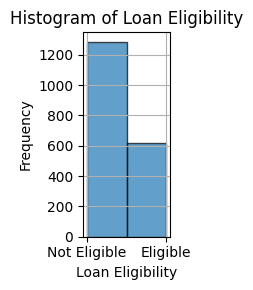

Counts of 1 and 0 in 'loan_eligibility' column:
loan_eligibility
0    1284
1     620
Name: count, dtype: int64
Percentage of 'loan_eligibility' = 1: 32.56%


In [24]:
# Plot histogram
plt.figure(figsize=(2, 3))
plt.hist(merged_data['loan_eligibility'], bins=[0, 0.5, 1], edgecolor='black', alpha=0.7)
plt.xlabel('Loan Eligibility')
plt.ylabel('Frequency')
plt.title('Histogram of Loan Eligibility')
plt.xticks([0, 1], ['Not Eligible', 'Eligible'])
plt.grid(True)
plt.tight_layout()
plt.show()
count_approved = merged_data['loan_eligibility'].value_counts()

# Print the counts
print("Counts of 1 and 0 in 'loan_eligibility' column:")
print(count_approved)

# Calculate percentage of loan_eligibility = 1
percentage_approved = (count_approved[1] / len(merged_data)) * 100

# Print the percentage
print(f"Percentage of 'loan_eligibility' = 1: {percentage_approved:.2f}%")

In [50]:
feature_columns = ['account_age_months', # 1. Age of account
                   'avg_monthly_balance', #2. Average monthly balance
                   'avg_weekly_balance', #3. Average weekly balance
                   'norm_num_net_positive_months', # 4. Number of months where deposits exceed witdrawls. Normalized
                   'avg_monthly_positive', # 5. Monthly average amount by which withdrawals exceed deposits. Normalized
                   'norm_num_net_positive_weeks', # 6. Number of weeks where deposits exceed witdrawls. Normalized
                   'avg_weekly_positive'] # 7. Weekly average amount by which withdrawals exceed deposits. Normalized

# Calculate mean and standard deviation for each feature
for feature in feature_columns:
    mean_value = new_data[feature].mean()
    std_dev = new_data[feature].std()
    print(f"{feature}  Mean: {mean_value:.2f}   Standard Deviation: {std_dev:.2f}")

account_age_months  Mean: 9.95   Standard Deviation: 4.73
avg_monthly_balance  Mean: -11.47   Standard Deviation: 200.63
avg_weekly_balance  Mean: -1.20   Standard Deviation: 65.14
norm_num_net_positive_months  Mean: 0.53   Standard Deviation: 0.21
avg_monthly_positive  Mean: 575.80   Standard Deviation: 1089.22
norm_num_net_positive_weeks  Mean: 0.48   Standard Deviation: 0.17
avg_weekly_positive  Mean: 525.07   Standard Deviation: 675.32


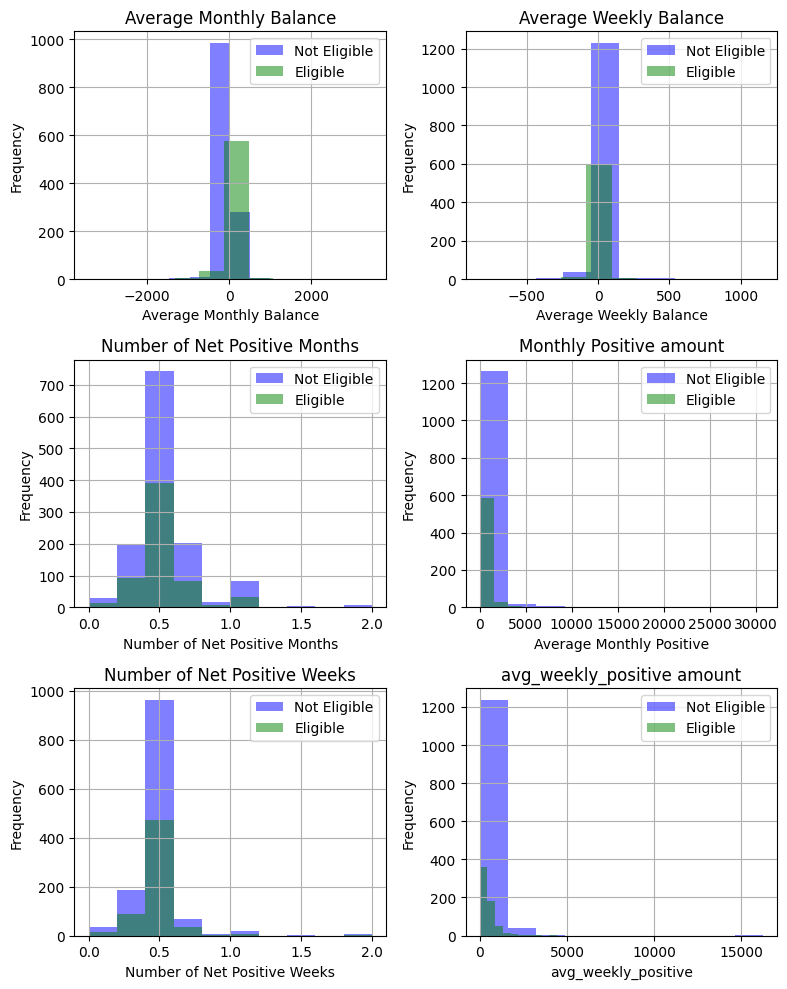

In [49]:
# Flotting Features
fig, axs = plt.subplots(3, 2, figsize=(8, 10))

# Histogram 1: Average Monthly Balance
axs[0, 0].hist(merged_data['avg_monthly_balance'][merged_data['loan_eligibility'] == 0], bins=10, alpha=0.5, color='blue', label='Not Eligible')
axs[0, 0].hist(merged_data['avg_monthly_balance'][merged_data['loan_eligibility'] == 1], bins=10, alpha=0.5, color='green', label='Eligible')
axs[0, 0].set_xlabel('Average Monthly Balance')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Average Monthly Balance')
axs[0, 0].legend()
axs[0, 0].grid(True)
# Histogram 2: Average Weekly Balance
axs[0, 1].hist(merged_data['avg_weekly_balance'][merged_data['loan_eligibility'] == 0], bins=10, alpha=0.5, color='blue', label='Not Eligible')
axs[0, 1].hist(merged_data['avg_weekly_balance'][merged_data['loan_eligibility'] == 1], bins=10, alpha=0.5, color='green', label='Eligible')
axs[0, 1].set_xlabel('Average Weekly Balance')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].set_title('Average Weekly Balance')
axs[0, 1].legend()
axs[0, 1].grid(True)
# Histogram 3: Number of Net Positive Months
axs[1, 0].hist(merged_data['norm_num_net_positive_months'][merged_data['loan_eligibility'] == 0], bins=10, alpha=0.5, color='blue', label='Not Eligible')
axs[1, 0].hist(merged_data['norm_num_net_positive_months'][merged_data['loan_eligibility'] == 1], bins=10, alpha=0.5, color='green', label='Eligible')
axs[1, 0].set_xlabel('Number of Net Positive Months')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Number of Net Positive Months')
axs[1, 0].legend()
axs[1, 0].grid(True)
# Histogram 4: Average Monthly Positive
axs[1, 1].hist(merged_data['avg_monthly_positive'][merged_data['loan_eligibility'] == 0], bins=10, alpha=0.5, color='blue', label='Not Eligible')
axs[1, 1].hist(merged_data['avg_monthly_positive'][merged_data['loan_eligibility'] == 1], bins=10, alpha=0.5, color='green', label='Eligible')
axs[1, 1].set_xlabel('Average Monthly Positive')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Monthly Positive amount')
axs[1, 1].legend()
axs[1, 1].grid(True)
# Histogram 5: Number of Net Positive Weeks
axs[2, 0].hist(merged_data['norm_num_net_positive_weeks'][merged_data['loan_eligibility'] == 0], bins=10, alpha=0.5, color='blue', label='Not Eligible')
axs[2, 0].hist(merged_data['norm_num_net_positive_weeks'][merged_data['loan_eligibility'] == 1], bins=10, alpha=0.5, color='green', label='Eligible')
axs[2, 0].set_xlabel('Number of Net Positive Weeks')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_title('Number of Net Positive Weeks')
axs[2, 0].legend()
axs[2, 0].grid(True)
# Histogram 6: avg_weekly_positive
axs[2, 1].hist(merged_data['avg_weekly_positive'][merged_data['loan_eligibility'] == 0], bins=10, alpha=0.5, color='blue', label='Not Eligible')
axs[2, 1].hist(merged_data['avg_weekly_positive'][merged_data['loan_eligibility'] == 1], bins=10, alpha=0.5, color='green', label='Eligible')
axs[2, 1].set_xlabel('avg_weekly_positive')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].set_title('avg_weekly_positive amount')
axs[2, 1].legend()
axs[2, 1].grid(True)
# Adjust layout
plt.tight_layout()
plt.show()

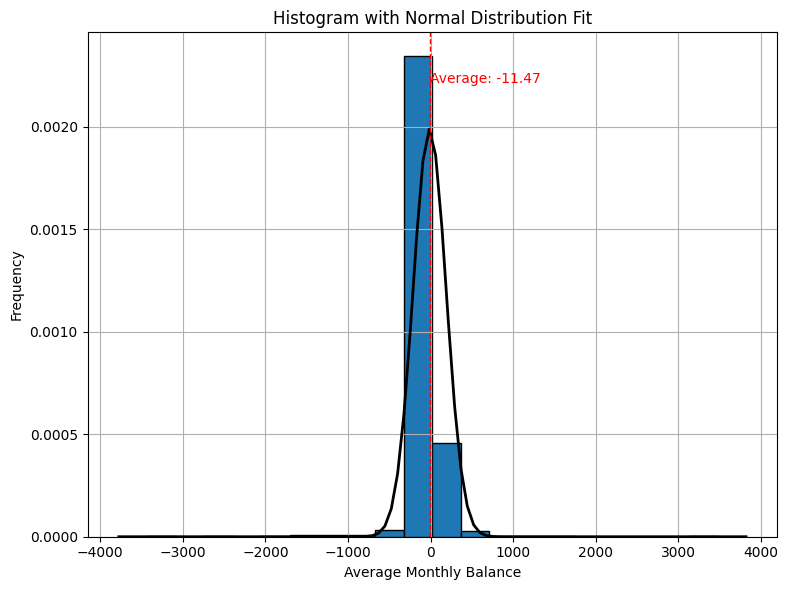

In [51]:
from scipy.stats import norm
plt.figure(figsize=(8, 6))

# Plot histogram for 'avg_monthly_balance'
plt.hist(new_data['avg_monthly_balance'], bins=20, edgecolor='black', density=True)  # density=True for normalized histogram

# Calculate mean and standard deviation
mean_balance = np.mean(new_data['avg_monthly_balance'])
std_dev = np.std(new_data['avg_monthly_balance'])

# Plot normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_balance, std_dev)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.xlabel('Average Monthly Balance')
plt.ylabel('Frequency')
plt.title('Histogram with Normal Distribution Fit')

# Add average balance label
plt.axvline(mean_balance, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_balance + 1, plt.ylim()[1] * 0.9, f'Average: {mean_balance:.2f}', color='red')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()


# <font color='purple'>Step 4, 5 and 6.</font>
## Selecting the right model for predicting loan eligibility based on transactional data depends on several factors, including the nature of the data, the complexity of the relationships within the data, and the need for interpretability versus predictive accuracy. Here are some model options and considerations for each:

#### Logistic Regression:

Pros: Simple, interpretable, works well with a linear relationship between features and the target.
Cons: May not capture complex relationships.
Use Case: When you need a simple, interpretable model to understand the influence of each feature on loan eligibility.
Decision Trees:

Pros: Simple to understand, can capture non-linear relationships.
Cons: Can be prone to overfitting, especially with deep trees.
Use Case: When you need a model that can capture non-linear relationships but is still relatively easy to interpret.

#### Random Forest:

Pros: Reduces overfitting by averaging multiple decision trees, can handle non-linear relationships.
Cons: Less interpretable than a single decision tree.
Use Case: When you need a more robust model that can handle complex relationships and interactions.

Others: Gradient Boosting Machines (e.g., XGBoost, LightGBM), Support Vector Machines (SVM), Neural Networks

### I'm choosing logistic regression and random forest for its simplicity and interpretability. And random forest for a balance between interpretability and the ability to capture complex relationships.

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
X = merged_data[feature_columns]
y = merged_data['loan_eligibility']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## <font color='red'>Logistic Regression</font>


In [53]:
# Initialize the logistic regression model
logreg_model = LogisticRegression()

# Fit the model to the training data
logreg_model.fit(X_train, y_train)

# look into regularization, L1 vs L2

LogisticRegression()

## <font color='red'>Random Forest</font>

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
# Initialize the random forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [56]:
# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Model Evaluation:
Accuracy: 0.6719160104986877

Confusion Matrix:
 [[239  21]
 [104  17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.92      0.79       260
           1       0.45      0.14      0.21       121

    accuracy                           0.67       381
   macro avg       0.57      0.53      0.50       381
weighted avg       0.62      0.67      0.61       381



|                | Predicted Negative (0) | Predicted Positive (1) |
|----------------|------------------------|------------------------|
| Actual Negative (0) | TN                     | FP                     |
| Actual Positive (1) | FN                     | TP                     |

### Classification Report
#### Accuracy: 0.9947 (or 99.47%) means that the model correctly predicted 99.47% of the total cases.
**Precision:**

- Precision for class 0: 1.00 (or 100%): Out of all predicted positives for class 0, all are actually positive.
- Precision for class 1: 0.99 (or 99%): Out of all predicted positives for class 1, 99% are actually positive.

**Recall:**

- Recall for class 0: 0.33 (or 33%): The model correctly identified 33% of all actual class 0 instances.
- Recall for class 1: 1.00 (or 100%): The model correctly identified all (100%) of the actual class 1 instances.

**F1-score:**

- F1-score for class 0: 0.50: The harmonic mean of precision and recall for class 0.
- F1-score for class 1: 1.00: The harmonic mean of precision and recall for class 1.

**Support:**

- Support for class 0: 3 instances.
- Support for class 1: 378 instances.

**Interpretation:**

- The model shows very high accuracy (99.47%), indicating strong overall performance in predicting both classes.
- For class 0, the recall is relatively low (33%), suggesting that the model identifies only a third of the actual instances of class 0. This could be a concern if identifying all instances of class 0 is crucial.
- Precision for both classes is high, especially for class 0, indicating that when the model predicts class 0, it is very likely to be correct.
- The F1-score for class 0 is lower compared to class 1, reflecting the balance between precision and recall for each class.
- In summary, while the model performs exceptionally well in terms of accuracy and precision for class 1, the lower recall for class 0 suggests potential room for improvement, especially if identifying all instances of class 0 is critical for your application.


# <font color='purple'>Step 6.</font>

|                | Predicted Negative (0) | Predicted Positive (1) |
|----------------|------------------------|------------------------|
| Actual Negative (0) | TN                     | FP                     |
| Actual Positive (1) | FN                     | TP                     |

In [57]:
# Make predictions on the test data
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Model Evaluation:
Accuracy: 0.6797900262467191

Confusion Matrix:
 [[259   1]
 [121   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.68      1.00      0.81       260
           1       0.00      0.00      0.00       121

    accuracy                           0.68       381
   macro avg       0.34      0.50      0.40       381
weighted avg       0.47      0.68      0.55       381



- True Positives (TP): 377 (predicted positive and actually positive)
- True Negatives (TN): 1 (predicted negative and actually negative)
- False Positives (FP): 2 (predicted positive but actually negative)
- False Negatives (FN): 1 (predicted negative but actually positive)

**Interpretation:**

- **Precision:**
  - Precision for class 0: 0.50 (or 50%): Out of all predicted positives for class 0, 50% are actually positive.
  - Precision for class 1: 0.99 (or 99%): Out of all predicted positives for class 1, 99% are actually positive.

- **Recall:**
  - Recall for class 0: 0.33 (or 33%): The model correctly identified 33% of all actual class 0 instances.
  - Recall for class 1: 1.00 (or 100%): The model correctly identified all (100%) of the actual class 1 instances.

- **F1-score:**
  - F1-score for class 0: 0.40: The harmonic mean of precision and recall for class 0.
  - F1-score for class 1: 1.00: The harmonic mean of precision and recall for class 1.

- **Support:**
  - Support for class 0: 3 instances.
  - Support for class 1: 378 instances.

- The model achieves high accuracy (99.21%), indicating strong overall performance in predicting both classes.
- However, for class 0, both precision and recall are lower compared to class 1, indicating that the model's performance in identifying instances of class 0 is less reliable.
- Precision for class 0 is relatively low, meaning when the model predicts class 0, it is correct only half of the time.
- The F|1-score for class 0 is also lower compared to class 1, indicating a balance between precision and recall that could be improved, especially for class 0.
- In summary, while the model performs very well for class 1, there is room for
